# **Introduction**
The goal of this program is to detect deception in videos using an MLP approach. For each video in the MU3D dataset, we first randomly take 40 frames. Then, we collect 478 facial landmarks from each frame and feed them into the MLP.<br><br>

Facial Landmarks (FLs) involves detecting and localizing specific points or landmarks on a face, such as the eyes, nose, mouth, and chin. We use Google MediaPipe to extract 478 landmarks, each with x and y coordinates. <br><br>




In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import glob
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

# Check for GPU availability and set device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

Mounted at /content/drive


# **Getting the Classified Output Y**

In [2]:
EXCEL_DATA_PATH  = '/content/drive/MyDrive/Deception_Detection/Datasets/MU3D-Package/MU3D Codebook.xlsx'
FOLDER = '/content/drive/MyDrive/Deception_Detection/Datasets/MU3D-Package'
SAVE_NPY_PATH = FOLDER + "/" + "NPY_FILES(240frames)"

df = pd.read_excel(EXCEL_DATA_PATH, sheet_name="Video-Level Data")

# Iterate through each row of the Excel file
truthfulness = {}
for index, row in df.iterrows():
  truthfulness[row["VideoID"]] = row["Veracity"]

# 0 indicates lie, 1 indicates truth

# **Getting the Input X**
We have 320 video. Each video is represented by a (240, 478, 2) array. For each video, let's first flatten it into a (229440,) array. Then, we will stack them and this will be our X values

In [3]:
import random

X_T = []
X_F = []
Y_T = []
Y_F = []

NUM_FRAMES_PER_VIDEO = 40

for file_path in glob.glob(SAVE_NPY_PATH+"/*", recursive = True):
  # Y Value
  output = truthfulness[Path(file_path).stem]

  # X Value
  selected_array = np.load(file_path)
  selected_array = selected_array.reshape(240, -1)

  # Randomly sample 40 frames for X value
  sampled_indices = random.sample(range(selected_array.shape[0]), NUM_FRAMES_PER_VIDEO)
  sampled_frames = selected_array[sampled_indices]


  # Place them into right category
  if output == 1:
    X_T.append(sampled_frames)
    Y_T.append([output])
  else:
    X_F.append(sampled_frames)
    Y_F.append([output])


X_T = np.stack(X_T, axis=0)
X_T = X_T.reshape(X_T.shape[0], -1)

X_F = np.stack(X_F, axis=0)
X_F = X_F.reshape(X_F.shape[0], -1)

Y_T = np.array(Y_T).reshape(-1, 1)
Y_F = np.array(Y_F).reshape(-1, 1)

X_T = torch.from_numpy(X_T).to(device)
X_F = torch.from_numpy(X_F).to(device)
Y_T = torch.from_numpy(Y_T).to(device)
Y_F = torch.from_numpy(Y_F).to(device)

X_T = X_T.float()
X_F = X_F.float()
Y_T = Y_T.float()
Y_F = Y_F.float()

print("X_T.shape", X_T.shape)
print("X_F.shape", X_F.shape)
print("Y_T.shape", Y_T.shape)
print("Y_F.shape", Y_F.shape)

X_T.shape torch.Size([160, 38240])
X_F.shape torch.Size([160, 38240])
Y_T.shape torch.Size([160, 1])
Y_F.shape torch.Size([160, 1])


# Data Split

In [ ]:
import torch.utils.data as data

# Split the shuffled data into 80% Training, 20% Testing
train_dataset_T, val_dataset_T = torch.utils.data.random_split(data.TensorDataset(X_T, Y_T), [0.8, 0.2])
train_dataset_F, val_dataset_F = torch.utils.data.random_split(data.TensorDataset(X_F, Y_F), [0.8, 0.2])

train_dataset = data.ConcatDataset([train_dataset_T, train_dataset_F])
val_dataset = data.ConcatDataset([val_dataset_T, val_dataset_F])

print("Training Dataset Size:", len(train_dataset))
print("Testing Dataset Size:", len(val_dataset))
print()

train_loader = data.DataLoader(train_dataset, batch_size=10, shuffle=True)

total_train_samples = len(train_dataset)
count_train_ones = sum(1 for _, label in train_dataset if label == 1)
percentage_train_ones = (count_train_ones / total_train_samples) * 100
print("Percentage of Y that are Truths in train_dataset:", percentage_train_ones)


test_loader = data.DataLoader(val_dataset, batch_size=1, shuffle=False)

total_val_samples = len(val_dataset)
count_val_ones = sum(1 for _, label in val_dataset if label == 1)
percentage_val_ones = (count_val_ones / total_val_samples) * 100
print("Percentage of Y that are Truths in val_dataset:", percentage_val_ones)


X_train_all = []
Y_train_all = []


# Iterate over the train_loader to accumulate the entire dataset
for X_train, Y_train in train_loader:
    X_train_all.append(X_train)
    Y_train_all.append(Y_train)

X_test_all = []
Y_test_all = []

for X_test, Y_test in test_loader:
    X_test_all.append(X_test)
    Y_test_all.append(Y_test)

X_test_all = torch.cat(X_test_all, dim=0).to(device)
Y_test_all = torch.cat(Y_test_all, dim=0).to(device)

X_train_all = torch.cat(X_train_all, dim=0).to(device)
Y_train_all = torch.cat(Y_train_all, dim=0).to(device)

Training Dataset Size: 256
Testing Dataset Size: 64

Percentage of Y that are Truths in train_dataset: 50.0
Percentage of Y that are Truths in val_dataset: 50.0


# 2-Layer MLP

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        # Define the input layer
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])

        # Define the hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        # Define the output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self,x):
        # Pass through input layer and apply activation function
        x = F.sigmoid(self.input_layer(x))

        # Pass through hidden layers and apply activation function
        for hidden_layer in self.hidden_layers:
            x = F.sigmoid(hidden_layer(x))

        # Pass through output layer
        x = F.sigmoid(self.output_layer(x))
        return x


-------------------
Epoch 0: train loss 0.6946, test loss 0.6946, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 1: train loss 0.6944, test loss 0.6945, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 2: train loss 0.6941, test loss 0.6943, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 3: train loss 0.6941, test loss 0.6943, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 4: train loss 0.6939, test loss 0.6942, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 5: train loss 0.6938, test loss 0.6941, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 6: train loss 0.6937, test loss 0.6941, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 7: train loss 0.6936, test loss 0.6940, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 8: train loss 0.6935, test loss 0.6940, train accuracy 0.5000, test accuracy 0.5000
----------

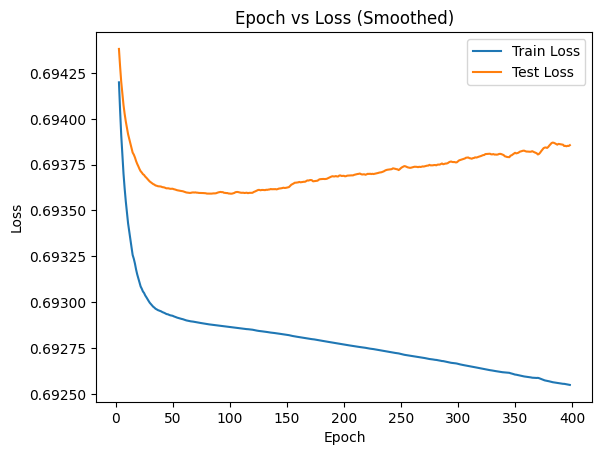

In [ ]:
import torch.utils.data as data
import matplotlib.pyplot as plt

# Lists to store training and test losses for each epoch
train_losses = []
test_losses = []

# Function to calculate accuracy
def accuracy(outputs, labels):
  preds = torch.round(outputs)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


criterion = nn.BCELoss()
model = MLP(input_size=38240, hidden_sizes=[32,16], output_size=1)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

num_epochs = 400

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        print("-------------------")
        # Calculate accuracy on training set
        y_pred = model(X_train_all)
        train_loss = criterion(y_pred, Y_train_all)
        train_acc = accuracy(y_pred, Y_train_all)

        # Calculate accuracy on test set
        y_pred = model(X_test_all)
        test_loss = criterion(y_pred, Y_test_all)

        test_acc = accuracy(y_pred, Y_test_all)

    print("Epoch %d: train loss %.4f, test loss %.4f, train accuracy %.4f, test accuracy %.4f" % (epoch, train_loss, test_loss, train_acc, test_acc))

    # Append the losses to the lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Smooth the losses using a moving average
window_size = 5
train_losses_smoothed = np.convolve(train_losses, np.ones(window_size) / window_size, mode='valid')
test_losses_smoothed = np.convolve(test_losses, np.ones(window_size) / window_size, mode='valid')

# Plotting epoch vs training loss and test loss
epochs = range(window_size // 2 + 1, num_epochs - window_size // 2 + 1)
plt.plot(epochs, train_losses_smoothed, label='Train Loss')
plt.plot(epochs, test_losses_smoothed, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss (Smoothed)')
plt.legend()
plt.show()

